Consider the 2DOF robotic structure from the figure below, for which $L1=L2=1 \;m$, $m1=m2=1\;kg$. The q1 and q2 initial conditions are $\pi$/4 and 1.
  
* Find the forward kinematics model using the D-H convention and create the robot using the robotics toolbox library DHRobot.
* Compute the C, D, and G matrices.    
* Implement in Python the robot model using the state space representation, with [odeintw](https://github.com/WarrenWeckesser/odeintw) (wrapper of odeint for working with matrices) for solving the MIMO diferential equations. Give two sine waves as the input joint torques.  
* Plot the positions and velocities compared with the inputs. Interpret the results.

<img src="../artwork/DynMod/2DOFstud.png" width=50% />

C:\Users\UTCN-C12\.conda\envs\rcs_labs\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


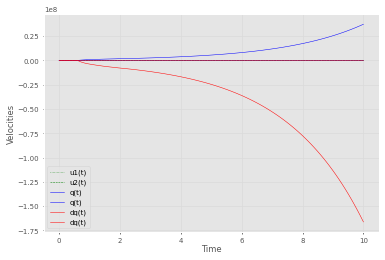

In [15]:
%reset -f
import numpy as np
import matplotlib.pyplot as plt
import roboticstoolbox as rtb
import math as m
from roboticstoolbox import *
from spatialmath import *
from spatialmath.base import * 
from lab_functions import lim_prismatic
from odeintw import *
from scipy.interpolate import *
from scipy.integrate import odeint

##########  2C, 2D ############

pr_lim = 10

def model(x, t, u):
    # Reshape input for matrix operations
    u = u.reshape(2, 1)
    
    # Extract positions and velocities
    q = x[:,0]  # Positions
    dq = x[:,1]  # Velocities
    
    # Apply prismatic joint limit
    lim_prismatic(q, dq, pr_lim)
    
    q1 = q[0]
    q2 = q[1]
    
    # Define the robot's physical parameters
    m1 = 1  # Mass of link 1
    m2 = 1  # Mass of link 2
    l1 = 1  # Length of link 1
    l2 = 1  # Length of link 2
    r1 = l1 / 2  # Distance from joint axis to center of mass of link 1
    r2 = l2 / 2  # Distance from joint axis to center of mass of link 2
    I1 = m1 * l1**2 / 12  # Moment of inertia of link 1
    I2 = m2 * l2**2 / 12  # Moment of inertia of link 2
    g = 9.81  # Acceleration due to gravity
    
    # Calculate the inertia matrix D(q)
    D = np.array([[I1 + m2*l1**2 + 2*m2*l1*r2*np.cos(q2), I2 + m2*l1*r2*np.cos(q2)],
                  [I2 + m2*l1*r2*np.cos(q2), I2]])
    
    # Calculate the Coriolis matrix C(q, dq)
    C = np.array([[-m2*l1*r2*np.sin(q2)*dq[1], -m2*l1*r2*np.sin(q2)*(dq[0]+dq[1])],
                  [m2*l1*r2*np.sin(q2)*dq[0], 0]])
    
    # Calculate the gravity vector G(q)
    G = np.array([[m1*g*r1*np.sin(q1) + m2*g*(l1*np.sin(q1) + r2*np.sin(q1+q2))],
                  [0]])
    
    # Inverse of inertia matrix
    D_inv = np.linalg.inv(D)
    
    # Compute the system acceleration (ddq)
    ddq = D_inv @ (u - C @ dq.reshape(2, 1) + G)
    
    # Combine the velocities and accelerations to form the state derivative
    xdot = np.concatenate((dq.reshape(2, 1), ddq), axis=1)
    
    return xdot.flatten()

# Initial conditions
x0 = np.array([[0, 0], [0, 0]])

n = 100 # Number of time points
t = np.linspace(0, 10, n) # Time points

# Control inputs as sine waves
u1 = np.sin(t)
u2 = np.sin(2*t)
u = np.array([u1, u2])

q  = np.empty((n,2))
dq = np.empty((n,2))

# Integrate the model over time using the interpolation function for u
# solve ODE for each step
for i in range(1,n):
    # span/period for next time step
    tspan = [t[i-1],t[i]]
    # solve for next step
    x = odeintw(model,x0,tspan,args=(u[:,i],))
    # store solution for plotting
    q[i,:]  = x[1][0,:]
    dq[i,:] = x[1][1,:]
    # next initial condition
    x0 = x[1]

# Plot results0
plt.figure()

plt.plot(t, u[0,:], 'g:', label='u1(t)')
plt.plot(t, u[1,:], 'g--', label='u2(t)')
plt.ylabel('Control Input')
plt.legend(loc='best')

plt.plot(t, q, 'b-', label='q(t)')
plt.ylabel('Positions')
plt.legend(loc='best')

plt.plot(t, dq, 'r-', label='dq(t)')
plt.ylabel('Velocities')
plt.xlabel('Time')
plt.legend(loc='best')

plt.show()

In [3]:
############### animation 
q = q.reshape(n,1)
l = 1
robot = DHRobot([ RevoluteMDH(alpha=m.pi/2, offset=m.pi/2), RevoluteMDH(d=l, alpha=m.pi/2), ], base=SE3(0.6, 0, 0), name = '2DOF robot')
zers  = np.zeros_like(q)
coord = np.concatenate((q,zers),axis=1)
robot.plot(coord, movie='1dof.gif', dt=tf/n, shadow=False)

ValueError: cannot reshape array of size 200 into shape (100,1)